# NBAPositionify: Leveraging Data Mining Techniques to Classify Professional Basketball Players into Positions

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Get Dataset from Kaggle
# Requires the kaggle package to download dataset. Uncomment the line below to install
# !pip3 install kaggle
import kaggle
# Requires kaggle.json (Kaggle API Key) placed in ~/.kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files("drgilermo/nba-players-stats", path="./data/", unzip=True)

## Exploratory Data Analysis

Our data is from `basketball-reference.com`. Three datasets:

In [3]:
player_data = pd.read_csv("./data/player_data.csv")
player_data.head(1)

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University


In [4]:
players = pd.read_csv("./data/Players.csv")
players.head(1)

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN


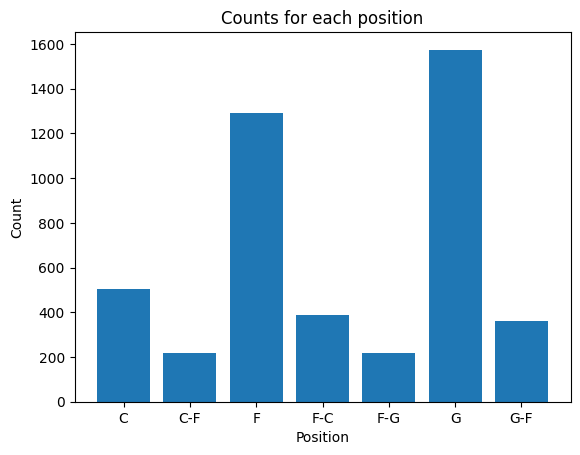

In [5]:
plt.bar(player_data.groupby('position').size().index, player_data.groupby('position').size().values)
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Counts for each position')
plt.show()

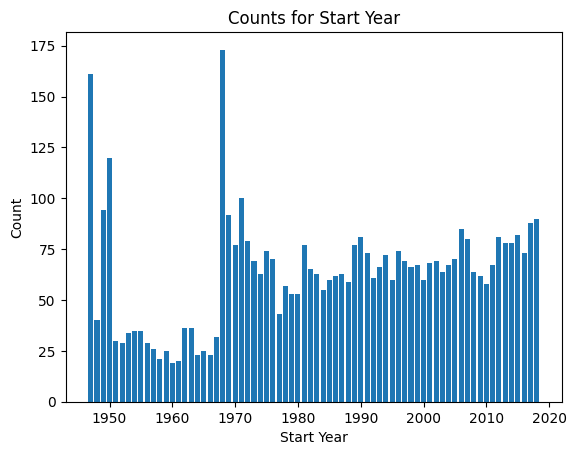

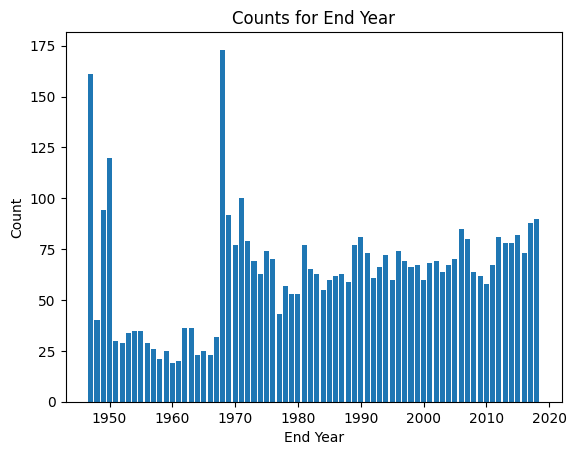

In [6]:
plt.bar(player_data.groupby('year_start').size().index, player_data.groupby('year_start').size().values)
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.title('Counts for Start Year')
plt.show()

plt.bar(player_data.groupby('year_start').size().index, player_data.groupby('year_start').size().values)
plt.xlabel('End Year')
plt.ylabel('Count')
plt.title('Counts for End Year')
plt.show()

In [7]:
stats = pd.read_csv("Seasons_Stats.csv")
stats = stats.rename(columns={"Unnamed: 0" : "Index"})
for index, row in stats.iterrows():
    if not pd.isna(row["Pos"]):
        positions = row["Pos"].split("-")
        print(positions)
        stats.at[index, "Pos"] = positions[0]
        for i in range(1, len(positions)):
            position = positions[i]
            new_row = stats.iloc[index].copy()
            new_row["Pos"] = position
            stats.loc[len(stats)] = new_row
stats.head()
stats.to_csv("season_stats_separated_pos.csv")

['G', 'F']
['SG']
['SF']
['F']
['F']
['F']
['G']
['G', 'F']
['F', 'C']
['F', 'C']
['F', 'C']
['PG']
['F', 'C']
['SF']
['F', 'G']
['C']
['G']
['PF']
['G', 'F']
['G']
['F', 'G']
['F']
['C']
['PF']
['G']
['F', 'G']
['SG']
['G', 'F']
['F', 'C']
['F', 'C']
['F', 'C']
['F', 'C']
['PG']
['F', 'C']
['F', 'C']
['F', 'C']
['F']
['SF']
['G', 'F']
['G', 'F']
['G', 'F']
['PF']
['G', 'F']
['G']
['F', 'C']
['PF']
['G']
['G']
['G']
['PG']
['F']
['F']
['G']
['F', 'C']
['G']
['F', 'C']
['SF']
['F', 'C']
['F', 'C']
['F', 'C']
['G']
['F', 'G']
['F', 'G']
['F', 'G']
['F', 'G']
['G']
['F', 'G']
['SG']
['PF']
['SG']
['F', 'C']
['F', 'C']
['SG']
['G']
['F', 'G']
['F', 'C']
['F', 'C']
['F', 'C']
['F', 'C']
['F']
['F']
['F', 'C']
['F']
['F', 'G']
['C']
['F', 'G']
['F', 'G']
['F', 'G']
['C']
['C']
['G', 'F']
['G', 'F']
['PF']
['G', 'F']
['F', 'C']
['G']
['G']
['G']
['G']
['F']
['C']
['C']
['C']
['G']
['C', 'F']
['G']
['G', 'F']
['SF']
['PG']
['F']
['F']
['F', 'G']
['G']
['SF']
['PG']
['PG']
['PG']
['PF']
['C']
[

# Unsupervised Naive K-Means Clustering (Points, Rebounds, Assists, Steals, Blocks)

As part of our exploratory data analysis, we did a round of naive k-means clustering, taking into account 5 stat columns which are subjectively "most relevant" to player performance and player type: points, rebounds, assists, steals and blocks. We used 5 clusters in the hopes of seeing each cluster group associated with a different position. The results yielded clusters which had datapoints evenly distributed between the 5 position classes. We hypothesized that a reason for this could be a lack of data preprocessing - some players had more stats than others, so they would be grouped in a similar class, regardless of which stats stood out. To that end, we decided to try multiple types of preprocessing on these columns - division by the number of minutes played, and normalization.

In [8]:
from sklearn.cluster import KMeans

unsupervised_kmeans_stats = stats[["PTS", "ORB", "DRB", "AST", "STL", "BLK"]].dropna()

unsupervised_kmeans_stats_1 = unsupervised_kmeans_stats.copy()
kmeans = KMeans(n_clusters=5)
kmeans.fit(unsupervised_kmeans_stats_1)

unsupervised_kmeans_stats_1["cluster"] = kmeans.labels_
unsupervised_kmeans_stats_1.insert(0, "Pos", stats["Pos"])
unsupervised_kmeans_stats_1.head()

,Pos,PTS,ORB,DRB,AST,STL,BLK,cluster
3851,C,865.0,259.0,664.0,166.0,80.0,104.0,2
3852,C,2191.0,287.0,891.0,386.0,112.0,283.0,4
3853,SF,759.0,133.0,315.0,141.0,110.0,12.0,2
3854,PG,182.0,16.0,53.0,56.0,36.0,1.0,0
3855,PG,1268.0,89.0,202.0,374.0,137.0,22.0,1


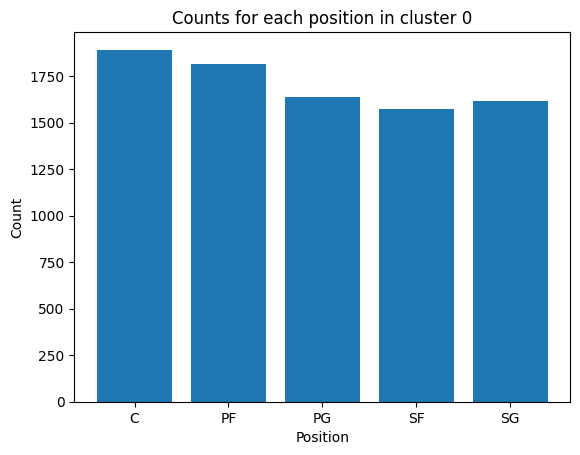

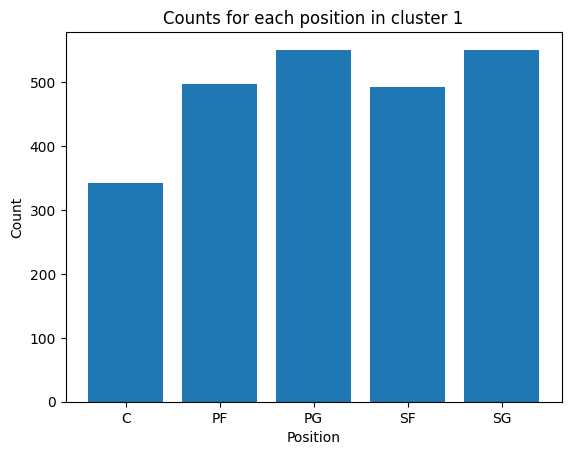

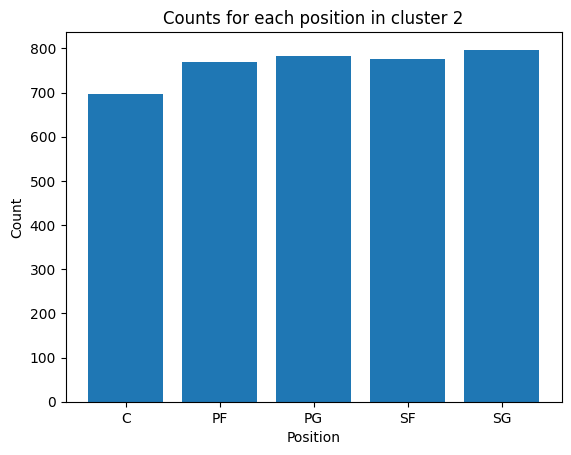

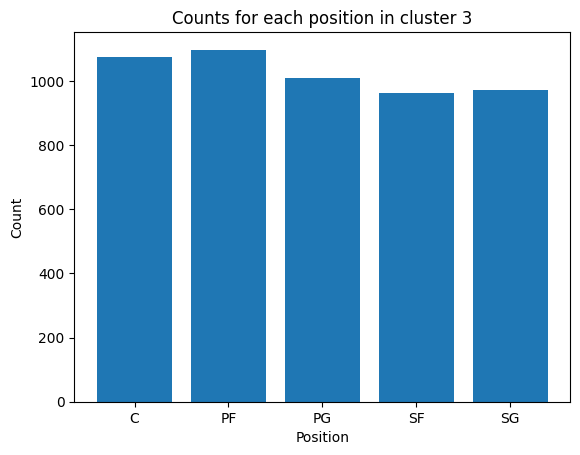

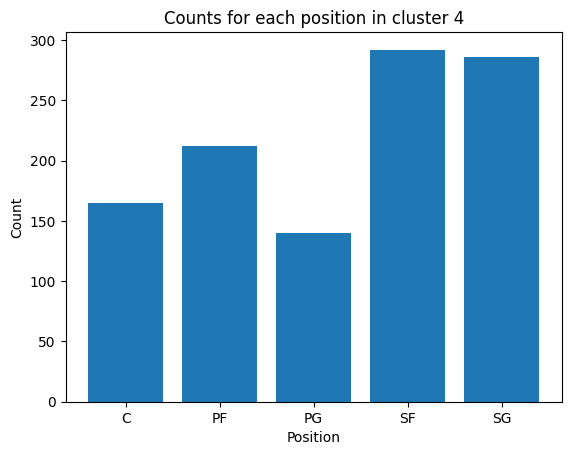

In [9]:
for cluster in range(5):
    cur_df = unsupervised_kmeans_stats_1.loc[unsupervised_kmeans_stats_1["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

### Normalization

In [10]:
# Normalization
unsupervised_kmeans_stats_2 = (unsupervised_kmeans_stats-unsupervised_kmeans_stats.mean())/unsupervised_kmeans_stats.std()

kmeans = KMeans(n_clusters=5)
kmeans.fit(unsupervised_kmeans_stats_2)

unsupervised_kmeans_stats_2["cluster"] = kmeans.labels_
unsupervised_kmeans_stats_2.insert(0, "Pos", stats["Pos"])
unsupervised_kmeans_stats_2.head()

,Pos,PTS,ORB,DRB,AST,STL,BLK,cluster
3851,C,0.764401,2.931790,3.550634,0.388506,1.039005,2.161562,1
3852,C,3.507900,3.348581,5.109527,1.994608,1.867051,7.022579,1
3853,SF,0.545087,1.056232,1.153922,0.205994,1.815298,-0.336838,2
3854,PG,-0.648728,-0.685358,-0.645328,-0.414545,-0.099557,-0.635560,0
3855,PG,1.598210,0.401275,0.377910,1.907002,2.513961,-0.065273,3


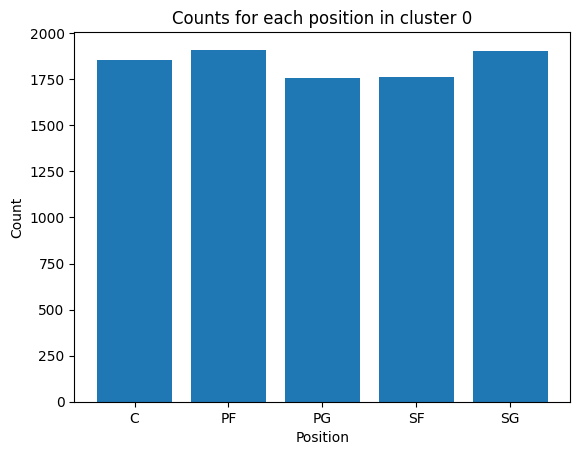

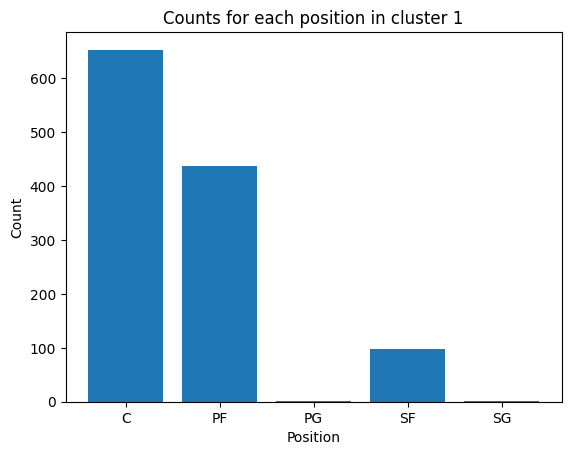

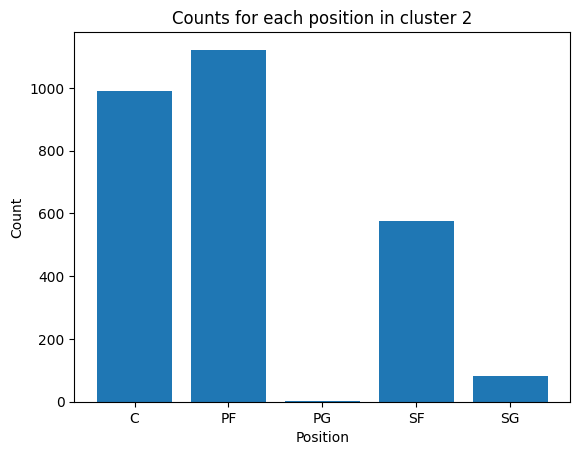

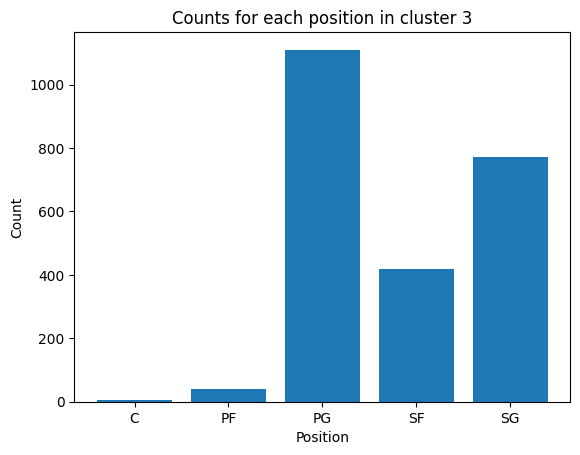

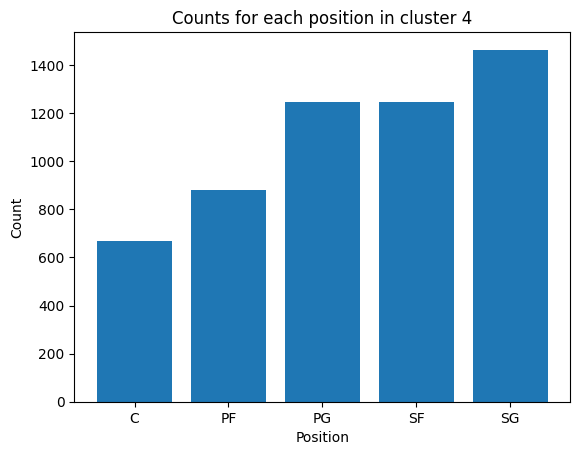

In [11]:
for cluster in range(5):
    cur_df = unsupervised_kmeans_stats_2.loc[unsupervised_kmeans_stats_2["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

### Division by Number of Minutes

In [12]:
# TODO: Division by number of minutes
unsupervised_kmeans_stats_3 = unsupervised_kmeans_stats.copy()
unsupervised_kmeans_stats_3.insert(0, "MIN", stats["MP"])
unsupervised_kmeans_stats_3[["PTS", "ORB", "DRB", "AST", "STL", "BLK"]] = (
    unsupervised_kmeans_stats_3[["PTS", "ORB", "DRB", "AST", "STL", "BLK"]].div(unsupervised_kmeans_stats_3["MIN"], axis=0)
)
unsupervised_kmeans_stats_3 = unsupervised_kmeans_stats_3.drop("MIN", axis=1).dropna()

kmeans = KMeans(n_clusters=5)
kmeans.fit(unsupervised_kmeans_stats_3)

unsupervised_kmeans_stats_3["cluster"] = kmeans.labels_
unsupervised_kmeans_stats_3.insert(0, "Pos", stats["Pos"])
unsupervised_kmeans_stats_3.head()

,Pos,PTS,ORB,DRB,AST,STL,BLK,cluster
3851,C,0.351769,0.105327,0.270028,0.067507,0.032534,0.042294,3
3852,C,0.617531,0.080891,0.251127,0.108794,0.031567,0.079763,1
3853,SF,0.330287,0.057876,0.137076,0.061358,0.047868,0.005222,3
3854,PG,0.294498,0.025890,0.085761,0.090615,0.058252,0.001618,4
3855,PG,0.530988,0.037270,0.084590,0.156616,0.057370,0.009213,1


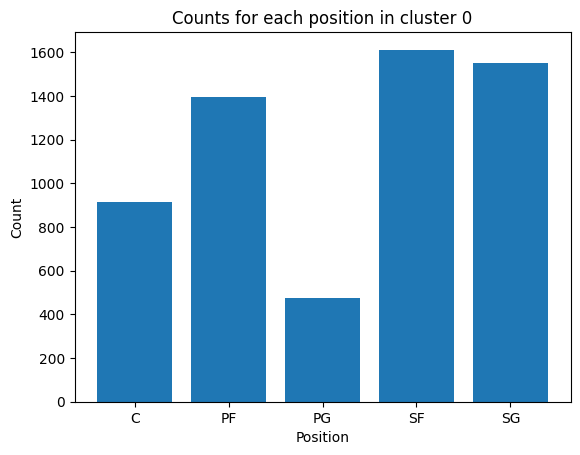

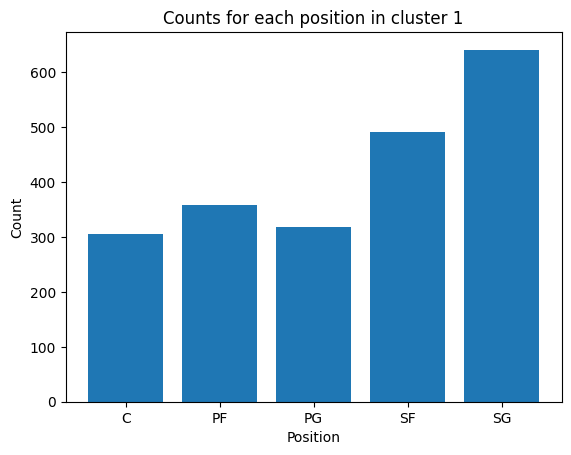

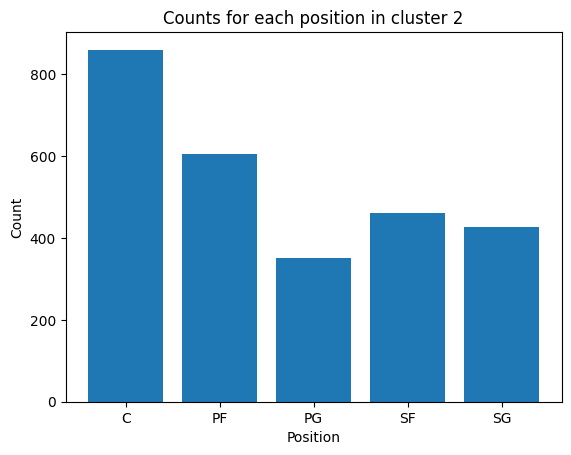

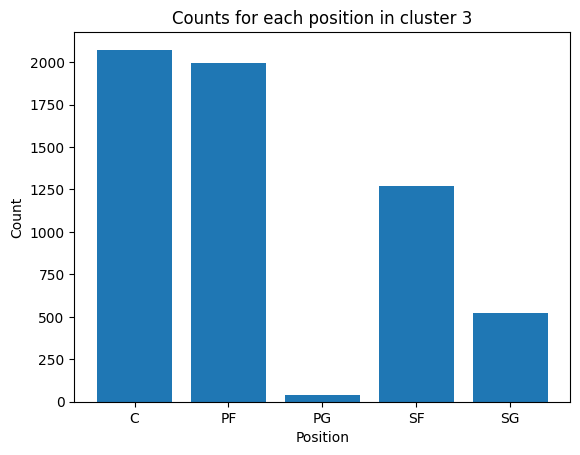

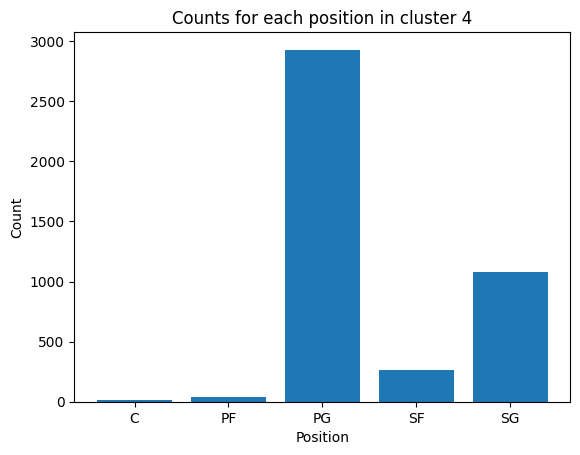

In [13]:
for cluster in range(5):
    cur_df = unsupervised_kmeans_stats_3.loc[unsupervised_kmeans_stats_3["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

In [14]:
for column in stats:
    print(column)

Index
Year
Player
Pos
Age
Tm
G
GS
MP
PER
TS%
3PAr
FTr
ORB%
DRB%
TRB%
AST%
STL%
BLK%
TOV%
USG%
blanl
OWS
DWS
WS
WS/48
blank2
OBPM
DBPM
BPM
VORP
FG
FGA
FG%
3P
3PA
3P%
2P
2PA
2P%
eFG%
FT
FTA
FT%
ORB
DRB
TRB
AST
STL
BLK
TOV
PF
PTS


# Agglomerative Clustering

In [15]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_stats = stats[["PTS", "ORB", "DRB", "AST", "STL", "BLK"]].dropna()

agglomerative_stats_1 = agglomerative_stats.copy()
agglomerative_clustering = AgglomerativeClustering(n_clusters=5)
agglomerative_clustering.fit(agglomerative_stats_1)

agglomerative_stats_1["cluster"] = agglomerative_clustering.labels_
agglomerative_stats_1.insert(0, "Pos", stats["Pos"])
agglomerative_stats_1.head()

,Pos,PTS,ORB,DRB,AST,STL,BLK,cluster
3851,C,865.0,259.0,664.0,166.0,80.0,104.0,0
3852,C,2191.0,287.0,891.0,386.0,112.0,283.0,1
3853,SF,759.0,133.0,315.0,141.0,110.0,12.0,0
3854,PG,182.0,16.0,53.0,56.0,36.0,1.0,4
3855,PG,1268.0,89.0,202.0,374.0,137.0,22.0,0


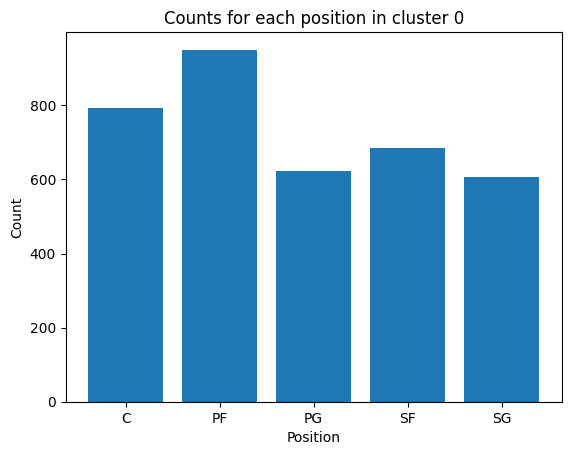

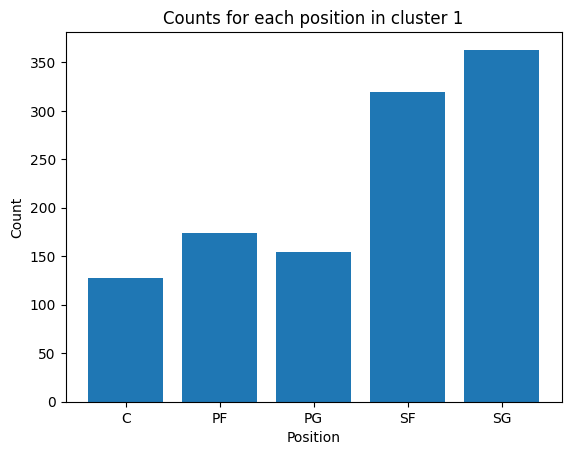

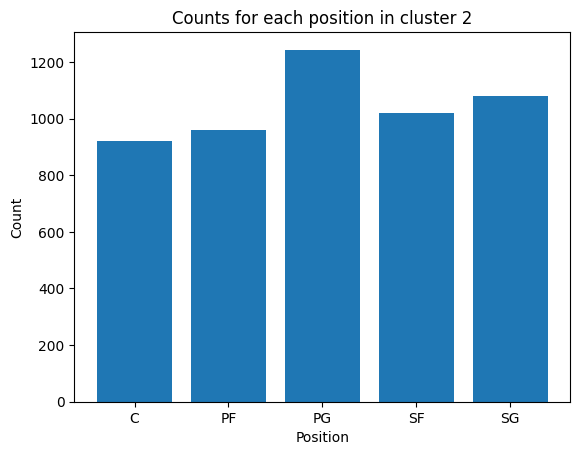

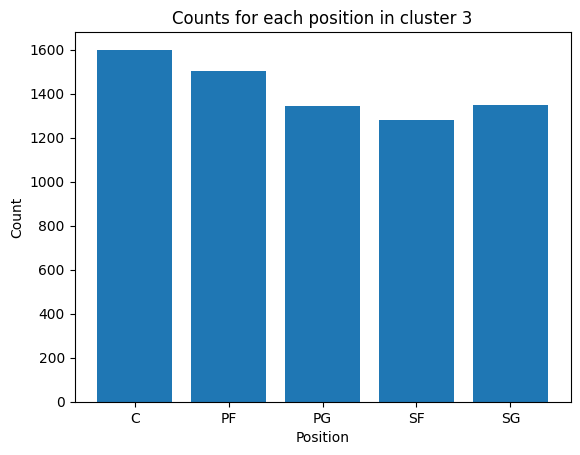

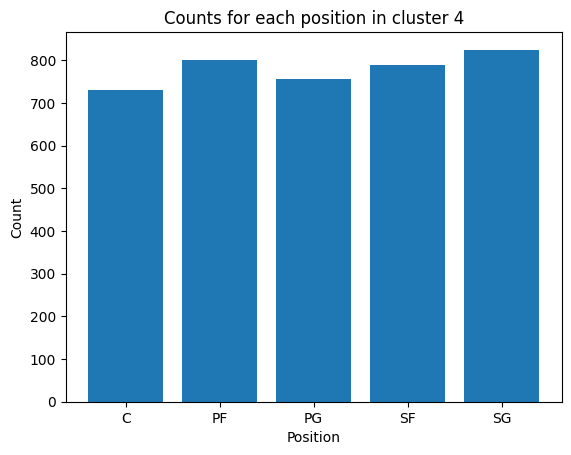

In [16]:
for cluster in range(5):
    cur_df = agglomerative_stats_1.loc[agglomerative_stats_1["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

### Normalization

In [17]:
# Normalization
agglomerative_stats_2 = (agglomerative_stats-agglomerative_stats.mean())/agglomerative_stats.std()

agglomerative_clustering = AgglomerativeClustering(n_clusters=5)
agglomerative_clustering.fit(agglomerative_stats_2)

agglomerative_stats_2["cluster"] = agglomerative_clustering.labels_
agglomerative_stats_2.insert(0, "Pos", stats["Pos"])
agglomerative_stats_2.head()

,Pos,PTS,ORB,DRB,AST,STL,BLK,cluster
3851,C,0.764401,2.931790,3.550634,0.388506,1.039005,2.161562,4
3852,C,3.507900,3.348581,5.109527,1.994608,1.867051,7.022579,2
3853,SF,0.545087,1.056232,1.153922,0.205994,1.815298,-0.336838,0
3854,PG,-0.648728,-0.685358,-0.645328,-0.414545,-0.099557,-0.635560,1
3855,PG,1.598210,0.401275,0.377910,1.907002,2.513961,-0.065273,0


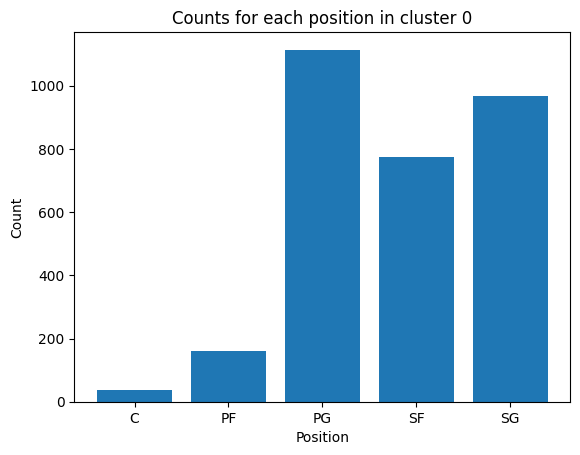

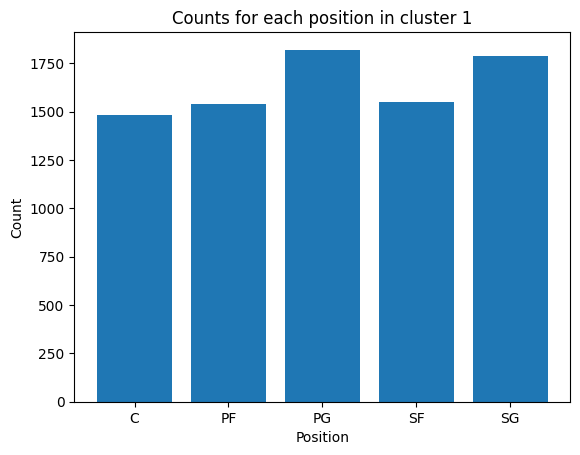

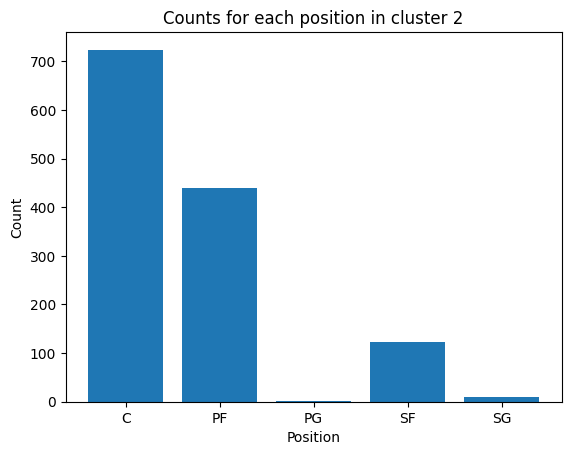

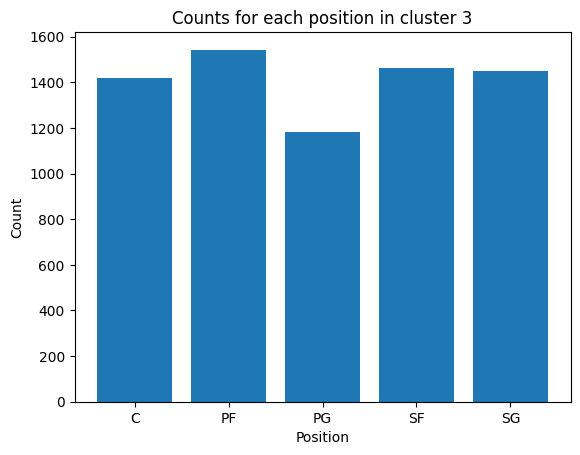

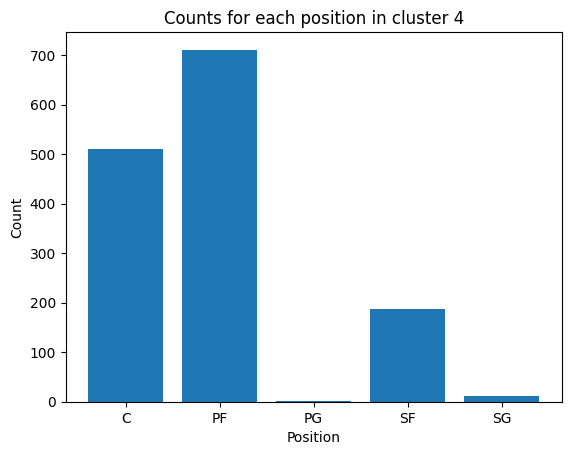

In [18]:
for cluster in range(5):
    cur_df = agglomerative_stats_2.loc[agglomerative_stats_2["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

### Normalization with 3 Clusters

In [19]:
# Normalization
agglomerative_stats_3 = (agglomerative_stats-agglomerative_stats.mean())/agglomerative_stats.std()

agglomerative_clustering = AgglomerativeClustering(n_clusters=3)
agglomerative_clustering.fit(agglomerative_stats_3)

agglomerative_stats_3["cluster"] = agglomerative_clustering.labels_
agglomerative_stats_3.insert(0, "Pos", stats["Pos"])
agglomerative_stats_3.head()

,Pos,PTS,ORB,DRB,AST,STL,BLK,cluster
3851,C,0.764401,2.931790,3.550634,0.388506,1.039005,2.161562,1
3852,C,3.507900,3.348581,5.109527,1.994608,1.867051,7.022579,1
3853,SF,0.545087,1.056232,1.153922,0.205994,1.815298,-0.336838,2
3854,PG,-0.648728,-0.685358,-0.645328,-0.414545,-0.099557,-0.635560,0
3855,PG,1.598210,0.401275,0.377910,1.907002,2.513961,-0.065273,2


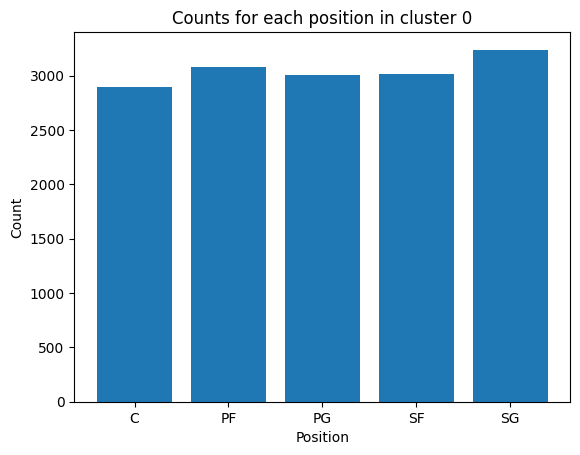

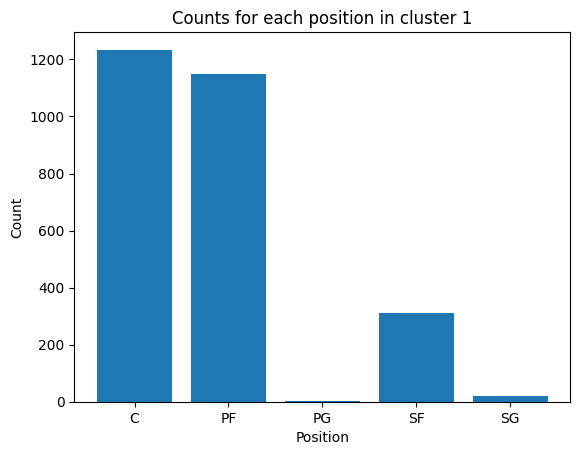

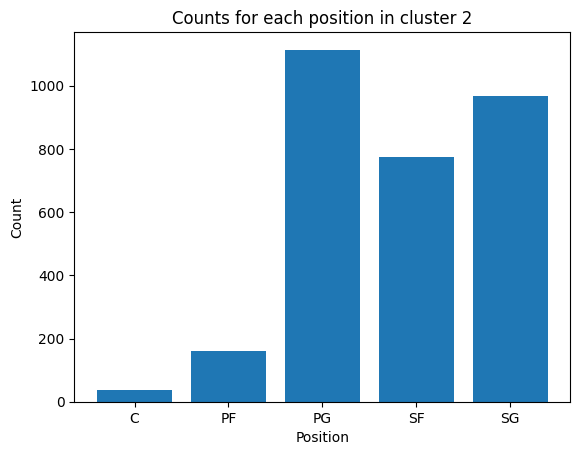

In [20]:
for cluster in range(3):
    cur_df = agglomerative_stats_3.loc[agglomerative_stats_3["cluster"] == cluster]
    plt.bar(cur_df.groupby('Pos').size().index, cur_df.groupby('Pos').size().values)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(f'Counts for each position in cluster {cluster}')
    plt.show()

# Outlier Analysis - From Clustering

Visual observation of the counts from clusters 1 and 2 shows that cluster 1 contains mostly backcourt players - those playing center or power forward. Similarly, cluster 2 conatins mostly frontcourt players - those playing point guard and shooting guard. As a result, we'll inspect the player info of the rows in those clusters which do not fit within those groups and therefore can be classified as "outliers" in a sense.

In [40]:
cluster_1 = agglomerative_stats_3.loc[agglomerative_stats_3["cluster"] == 1]
cluster_1.head()
cluster_1_pg_outliers = cluster_1.loc[cluster_1["Pos"] == "PG"]
cluster_1_sg_outliers = cluster_1.loc[cluster_1["Pos"] == "SG"]
cluster_1_outliers = pd.concat([cluster_1_pg_outliers, cluster_1_sg_outliers], axis=0)
stats.loc[cluster_1_outliers.index.values]

,Index,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
6252,6252,1981.0,Vinnie Johnson,PG,24.0,SEA,81.0,NaN,2311.0,16.8,...,0.793,193.0,173.0,366.0,341.0,78.0,20.0,216.0,198.0,1053.0
8638,8638,1987.0,Darrell Walker,PG,25.0,DEN,81.0,25.0,2020.0,15.8,...,0.745,157.0,170.0,327.0,282.0,120.0,37.0,187.0,229.0,988.0
23537,23537,2016.0,Giannis Antetokounmpo,PG,21.0,MIL,80.0,79.0,2823.0,18.8,...,0.724,113.0,499.0,612.0,345.0,94.0,113.0,208.0,258.0,1350.0
3884,3884,1974.0,Don Chaney,SG,27.0,BOS,81.0,NaN,2258.0,12.9,...,0.828,210.0,168.0,378.0,176.0,83.0,62.0,NaN,247.0,845.0
4151,4151,1975.0,Don Chaney,SG,28.0,BOS,82.0,NaN,2208.0,12.9,...,0.806,171.0,199.0,370.0,181.0,122.0,66.0,NaN,244.0,775.0
4807,4807,1977.0,Dennis Johnson*,SG,22.0,SEA,81.0,NaN,1667.0,16.7,...,0.624,161.0,141.0,302.0,123.0,123.0,57.0,NaN,221.0,749.0
5135,5135,1978.0,George Gervin*,SG,25.0,SAS,82.0,NaN,2857.0,24.7,...,0.830,118.0,302.0,420.0,302.0,136.0,110.0,306.0,255.0,2232.0
5176,5176,1978.0,Dennis Johnson*,SG,23.0,SEA,81.0,NaN,2209.0,15.6,...,0.732,152.0,142.0,294.0,230.0,118.0,51.0,164.0,213.0,1031.0
5333,5333,1978.0,David Thompson*,SG,23.0,DEN,80.0,NaN,3025.0,23.2,...,0.778,156.0,234.0,390.0,362.0,92.0,99.0,245.0,213.0,2172.0
5848,5848,1980.0,George Gervin*,SG,27.0,SAS,78.0,NaN,2934.0,24.0,...,0.852,154.0,249.0,403.0,202.0,110.0,79.0,254.0,208.0,2585.0


In [42]:
cluster_2 = agglomerative_stats_3.loc[agglomerative_stats_3["cluster"] == 2]
cluster_2.head()
cluster_2_pf_outliers = cluster_2.loc[cluster_2["Pos"] == "PF"]
cluster_2_c_outliers = cluster_2.loc[cluster_2["Pos"] == "C"]
cluster_2_outliers = pd.concat([cluster_2_pf_outliers, cluster_2_c_outliers], axis=0)
stats.loc[cluster_2_outliers.index.values]

,Index,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
3976,3976,1974.0,Bob Love,PF,31.0,CHI,82.0,NaN,3292.0,13.7,...,0.818,183.0,309.0,492.0,130.0,84.0,28.0,NaN,221.0,1785.0
4248,4248,1975.0,Bob Love,PF,32.0,CHI,61.0,NaN,2401.0,15.0,...,0.830,99.0,286.0,385.0,102.0,63.0,12.0,NaN,209.0,1342.0
4987,4987,1977.0,Jamaal Wilkes*,PF,23.0,GSW,76.0,NaN,2579.0,16.8,...,0.797,155.0,423.0,578.0,211.0,127.0,16.0,NaN,222.0,1343.0
5025,5025,1978.0,Marvin Barnes,PF,25.0,TOT,60.0,NaN,1646.0,13.9,...,0.703,135.0,304.0,439.0,136.0,64.0,83.0,136.0,241.0,686.0
5098,5098,1978.0,Coby Dietrick,PF,29.0,SAS,79.0,NaN,1876.0,11.3,...,0.781,73.0,285.0,358.0,217.0,81.0,55.0,144.0,231.0,589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20545,20545,2011.0,Andrea Bargnani,C,25.0,TOR,66.0,66.0,2353.0,16.4,...,0.820,74.0,269.0,343.0,119.0,34.0,46.0,152.0,160.0,1414.0
22467,22467,2014.0,Marc Gasol,C,29.0,MEM,59.0,59.0,1970.0,18.2,...,0.768,84.0,340.0,424.0,215.0,59.0,76.0,111.0,150.0,859.0
23305,23305,2015.0,Zaza Pachulia,C,30.0,MIL,73.0,45.0,1730.0,15.6,...,0.788,197.0,303.0,500.0,178.0,80.0,21.0,133.0,170.0,606.0
23688,23688,2016.0,Marc Gasol,C,31.0,MEM,52.0,52.0,1791.0,17.7,...,0.829,58.0,304.0,362.0,196.0,50.0,70.0,118.0,141.0,861.0


# Outlier Detection - iForest Approach

_add description of iForest approach for outlier detection here_

In [27]:
from sklearn.ensemble import IsolationForest

def iForest(data, n_estimators=100, outlier_fraction='auto'):
    isolation_forest = IsolationForest(n_estimators=n_estimators, contamination=outlier_fraction)
    # Fit the model to the data
    isolation_forest.fit(data)
    # Use the model to predict the outliers
    outliers = isolation_forest.predict(data) == -1
    # Extract the rows with outliers
    outliers_only = data[outliers]
    # Extract the rows without outliers
    no_outliers =data[~outliers]
    return outliers_only, no_outliers

for cluster in range(3):
    cur_df = agglomerative_stats_3.loc[agglomerative_stats_3["cluster"] == cluster]
    # print(cur_df[["PTS", "ORB", "DRB", "AST", "STL", "BLK"]].head())
    outliers = iForest(cur_df[["PTS", "ORB", "DRB", "AST", "STL", "BLK"]])
    print(outliers)

(            PTS       ORB       DRB       AST       STL       BLK
3856   0.251288 -0.610932 -0.569787  1.118552  0.417971 -0.472621
3860   0.803712  0.207765 -0.006663  0.702426  0.417971 -0.363995
3868   0.451982  0.996690  0.776217 -0.137127  0.728488  0.287762
3870   0.449913 -0.685358 -0.480511  0.994444  0.521477 -0.418308
3887  -0.226651  0.341733  0.735013 -0.107925 -0.539456  0.206292
...         ...       ...       ...       ...       ...       ...
25145 -0.361137 -0.804442 -0.439307 -0.363442  0.159207  0.369231
25146  0.222322  0.163108  0.460318 -0.319639 -0.203063  0.532170
25154  0.087837 -0.417422 -0.274490  1.381369  0.029825 -0.581247
25157  0.543018 -0.625817  0.041409  1.534679 -0.228939 -0.526934
25158  0.265771  0.133338  0.721278 -0.414545  0.210960 -0.119586

[3104 rows x 6 columns],             PTS       ORB       DRB       AST       STL       BLK
3854  -0.648728 -0.685358 -0.645328 -0.414545 -0.099557 -0.635560
3857  -0.644590 -0.194141 -0.150878 -0.195531 -0.